### model.predict() method is used.
* two key arguments.
* tasks (or list if tasks) containing context data.
* a set of target prediction location.
* can predict on grid and off grid data based on the form X_t.

In [1]:
import logging
logging.captureWarnings(True)

import deepsensor.torch
from deepsensor.model import ConvNP
from deepsensor.train import Trainer, set_gpu_default_device
from deepsensor.data import DataProcessor, TaskLoader, construct_circ_time_ds
from deepsensor.data.sources import get_era5_reanalysis_data, get_earthenv_auxiliary_data, get_gldas_land_mask

import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

In [2]:
# Training/data config
data_range = ("2010-01-01", "2019-12-31")
train_range = ("2010-01-01", "2018-12-31")
val_range = ("2019-01-01", "2019-12-31")
date_subsample_factor = 2
extent = "north_america"
era5_var_IDs = ["2m_temperature"]
lowres_auxiliary_var_IDs = ["elevation"]
cache_dir = "mycache"
deepsensor_folder = "deepsensor_config/"
verbose_download = True

In [3]:
era5_raw_ds = get_era5_reanalysis_data(era5_var_IDs, extent, date_range=data_range, cache=True, cache_dir=cache_dir, verbose=verbose_download, num_processes=8)
lowres_aux_raw_ds = get_earthenv_auxiliary_data(lowres_auxiliary_var_IDs, extent, "100KM", cache=True, cache_dir=cache_dir, verbose=verbose_download)
land_mask_raw_ds = get_gldas_land_mask(extent, cache=True, cache_dir=cache_dir, verbose=verbose_download)

data_processor = DataProcessor(x1_name="lat", x2_name="lon")
era5_ds = data_processor(era5_raw_ds)
lowres_aux_ds, land_mask_ds = data_processor([lowres_aux_raw_ds, land_mask_raw_ds], method="min_max")

dates = pd.date_range(era5_ds.time.values.min(), era5_ds.time.values.max(), freq="D")
doy_ds = construct_circ_time_ds(dates, freq="D")
lowres_aux_ds["cos_D"] = doy_ds["cos_D"]
lowres_aux_ds["sin_D"] = doy_ds["sin_D"]

100%|██████████| 120/120 [00:01<00:00, 91.49it/s]


1.41 GB loaded in 1.72 s


In [4]:
task_loader = TaskLoader(
    context=[era5_ds, land_mask_ds, lowres_aux_ds],
    target=era5_ds,
)
task_loader.load_dask()
print(task_loader)

TaskLoader(3 context sets, 1 target sets)
Context variable IDs: (('2m_temperature',), ('GLDAS_mask',), ('elevation', 'cos_D', 'sin_D'))
Target variable IDs: (('2m_temperature',),)


In [5]:
set_gpu_default_device()

In [6]:
# Set up model
model = ConvNP(data_processor, task_loader)

dim_yc inferred from TaskLoader: (1, 1, 3)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 400
encoder_scales inferred from TaskLoader: [np.float32(0.00125), np.float32(0.00125), np.float32(0.0041666664)]
decoder_scale inferred from TaskLoader: 0.0025


### Predict on grid to xarray
* if X_t is an xarray object, then model.predict will return xarray predictions on the same grid as that object
* resolution optionally scaled by resolution_factor


In [7]:
date = "2019-06-25"
test_task = task_loader(date, [100, "all", "all"], seed_override=42)
pred = model.predict(test_task, X_t=era5_raw_ds, resolution_factor=1)

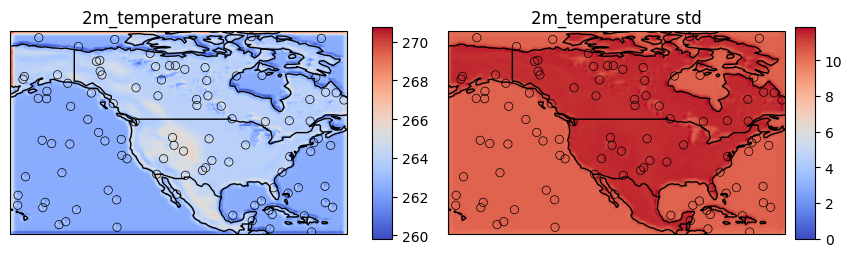

In [8]:
fig = deepsensor.plot.prediction(pred, date, data_processor, task_loader, test_task, crs=ccrs.PlateCarree(),cmap='coolwarm')

### Predict off-grid to pandas
* shape (2,N) numpy array. 
* a pandas object containing spatial indexes.


In [9]:
 # Predict at two off grid locations over 6 months of 2019 with 200 random context points(fixed across time).
test_tasks = task_loader(pd.date_range("2019-06-01", "2019-12-31"), [200, "all", "all"], seed_override=42)
X_t = np.array([[50,-80],
               [40,-110]]).T                # why this transpose ?
pred = model.predict(test_tasks, X_t=X_t)

In [10]:
test_tasks[0:2]

[time: Timestamp/2019-06-01 00:00:00
 ops: []
 X_c: ['ndarray/float32/(2, 200)', ('ndarray/float32/(1, 240)', 'ndarray/float32/(1, 400)'), ('ndarray/float32/(1, 72)', 'ndarray/float32/(1, 120)')]
 Y_c: ['ndarray/float32/(1, 200)', 'ndarray/float32/(1, 240, 400)', 'ndarray/float32/(3, 72, 120)']
 X_t: None
 Y_t: None,
 time: Timestamp/2019-06-02 00:00:00
 ops: []
 X_c: ['ndarray/float32/(2, 200)', ('ndarray/float32/(1, 240)', 'ndarray/float32/(1, 400)'), ('ndarray/float32/(1, 72)', 'ndarray/float32/(1, 120)')]
 Y_c: ['ndarray/float32/(1, 200)', 'ndarray/float32/(1, 240, 400)', 'ndarray/float32/(3, 72, 120)']
 X_t: None
 Y_t: None]

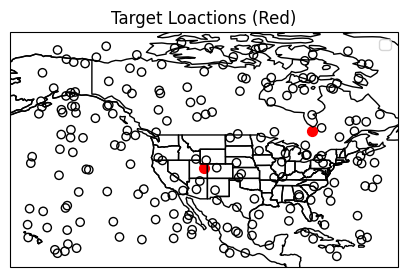

In [11]:
# Plot the target locations and the context loactions on a map.
fig, ax = plt.subplots(figsize = (5,5), subplot_kw={"projection": ccrs.PlateCarree()})
deepsensor.plot.offgrid_context(ax, test_tasks[0], data_processor, task_loader)
ax.scatter(X_t[1], X_t[0], c = "r", s = 50)
ax.coastlines()
ax.set_title("Target Loactions (Red)")
ax.add_feature(ccrs.cartopy.feature.STATES)

In [12]:
pred["2m_temperature"]

mean        std
time       lat lon                        
2019-06-01 50  -80   265.871704  11.355878
           40  -110  267.432098  11.397412
2019-06-02 50  -80   265.782196  11.364243
           40  -110  267.332733  11.400047
2019-06-03 50  -80    265.69104   11.37264
...                         ...        ...
2019-12-29 40  -110  268.330414  10.128339
2019-12-30 50  -80   270.719727  11.092607
           40  -110  268.375458  10.121411
2019-12-31 50  -80   270.748901  11.089479
           40  -110  268.422058  10.115027

[428 rows x 2 columns]

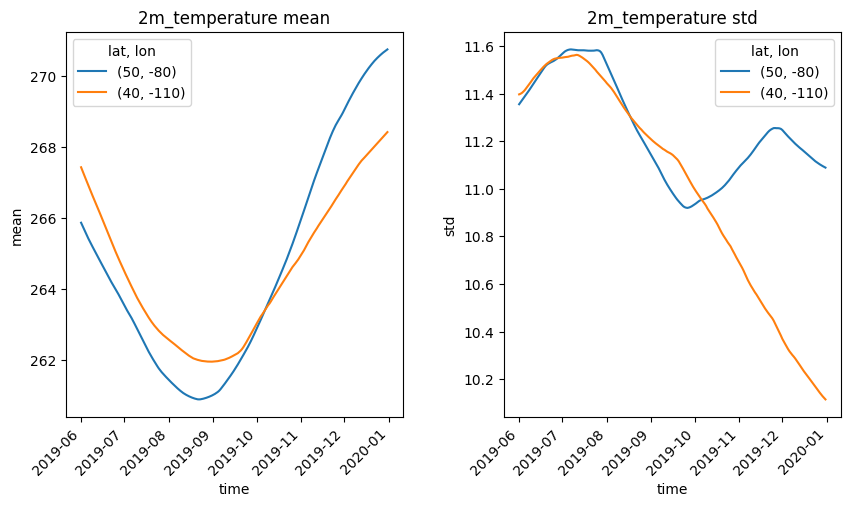

In [13]:
fig = deepsensor.plot.prediction(pred)

### Advanced : Autoregressive Sampling 
 * spatially correlated samples.
 * AR sampling works by passing model samples at target points back to the model as context pts.
 * In model.predict this is achieved by paasing n_samples > 0 with ar_sample.
 * Computationally expensive, requiers a forward pass of the model for each target point.
 * Deepsensor provides functionality to get cheaper AR samples, using a subset of target pts. and then interpoltae those samples with a single forward pass only.
 * This is achieved by passing an integer, ar_subsample_factor > 1,  

In [14]:
date = "2019-06-25"
test_task = task_loader(date, [100, "all", "all"], seed_override=42)
X_t = era5_raw_ds
pred = model.predict(test_task, X_t = X_t, n_samples=3, ar_sample=True, ar_subsample_factor=10)

In [16]:
pred["2m_temperature"]

<xarray.Dataset> Size: 2MB
Dimensions:   (time: 1, lat: 241, lon: 401)
Coordinates:
  * lat       (lat) float32 964B 75.0 74.75 74.5 74.25 ... 15.75 15.5 15.25 15.0
  * lon       (lon) float32 2kB -160.0 -159.8 -159.5 ... -60.5 -60.25 -60.0
  * time      (time) datetime64[ns] 8B 2019-06-25
Data variables:
    mean      (time, lat, lon) float32 387kB 270.6 270.7 270.8 ... 266.4 267.2
    std       (time, lat, lon) float32 387kB 9.82 9.91 9.946 ... 9.642 9.624
    sample_0  (time, lat, lon) float32 387kB 270.9 271.0 270.9 ... 266.9 267.9
    sample_1  (time, lat, lon) float32 387kB 270.9 271.0 270.9 ... 266.9 267.9
    sample_2  (time, lat, lon) float32 387kB 270.9 271.0 270.9 ... 266.9 267.9

### Plotting the difference between each AR sample and mean predictions to highlight to get spatial correlations we get in the AR samples.


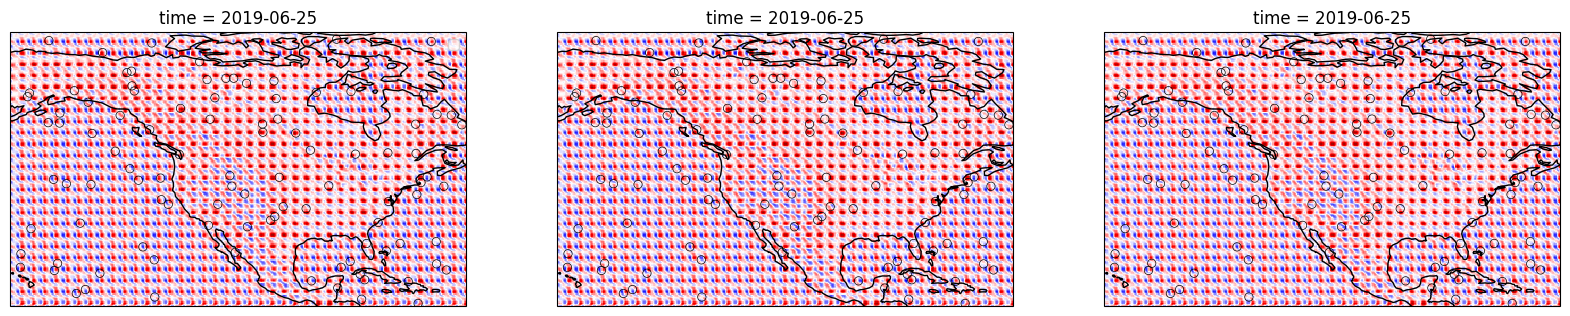

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,5), subplot_kw={"projection": ccrs.PlateCarree()})
for sample_i, ax in enumerate(axes):
    (pred["2m_temperature"][f"sample_{sample_i}"] - pred["2m_temperature"]["mean"]).plot(ax=ax, cmap="seismic", center = 0, add_colorbar = False)
    ax.coastlines()
deepsensor.plot.offgrid_context(axes, test_task, data_processor, task_loader, linewidth = 0.5)


KeyError: "No variable named 'sample_0'. Variables on the dataset include ['mean', 'std', 'lat', 'lon', 'time']"

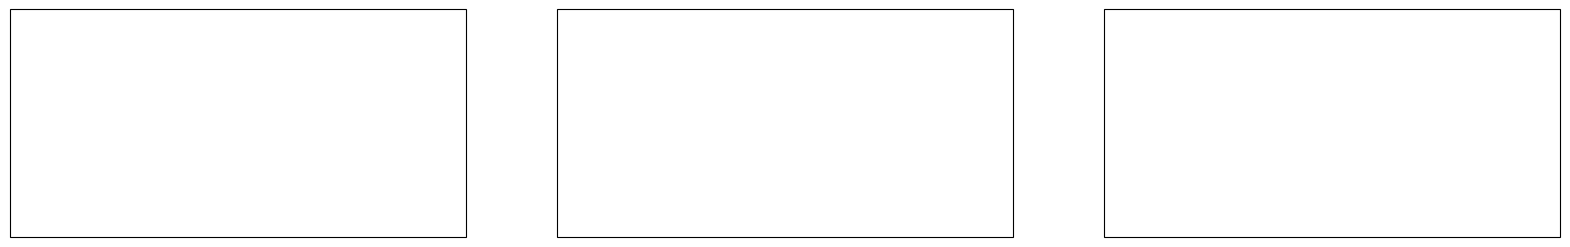

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5), subplot_kw={"projection": ccrs.PlateCarree()})
for sample_i, ax in enumerate(axes):
    (pred["2m_temperature"][f"sample_{sample_i}"] - pred["2m_temperature"]["mean"]).plot(ax=ax, cmap="seismic", center=0., add_colorbar=False)
    ax.coastlines()
deepsensor.plot.offgrid_context(axes, test_task, data_processor, task_loader, linewidth=0.5)
plt.show()